In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'mnist' in c['name']]

In [3]:
# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_encoder(cfg, path, device):
    enc = hydra.utils.instantiate(cfg)
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    enc.eval()
    enc.to(device)
    return enc

In [4]:
num_samples = 200
dataset = prepare_dataset(cfg[0]['config']['dataset'])

/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/mnist.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.mnist.targets)


In [5]:
encoder = load_encoder(cfg[0]['config']['encoder'], 
                       cfg[0]['dir'], 'cuda')

In [6]:
dataset.prob = np.array(dataset.prob)

In [7]:
fr = torch.tensor(dataset.fisher_rao_distance(dataset.prob[:num_samples]))

/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/mnist.py:161: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))


In [8]:
with torch.no_grad():
    x = torch.tensor(dataset.data[:num_samples], dtype=torch.float32).to(device)
    z = encoder(x)
    l2s = torch.cdist(z, z, p=2)

/tmp/ipykernel_2171825/1314233790.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset.data[:num_samples], dtype=torch.float32).to(device)


In [9]:
a, b = np.meshgrid(dataset.prob[:num_samples, 0], dataset.prob[:num_samples, 0])
pairs = np.stack([a.ravel(), b.ravel()], axis=1)

data = {
    "P1": pairs[:, 0],
    "P2": pairs[:, 1],
    "FR": fr.cpu().ravel(),
    "L2" : l2s.cpu().ravel()
}

In [10]:
df = pd.DataFrame(data)

In [11]:
df.head()

,P1,P2,FR,L2
0,0.134871,0.134871,0.000000,0.001953
1,0.843312,0.134871,0.787768,1.156362
2,0.028893,0.134871,0.205240,0.388853
3,0.983388,0.134871,1.065500,1.358341
4,0.882136,0.134871,0.844306,1.245832


<Axes: xlabel='FR', ylabel='L2'>

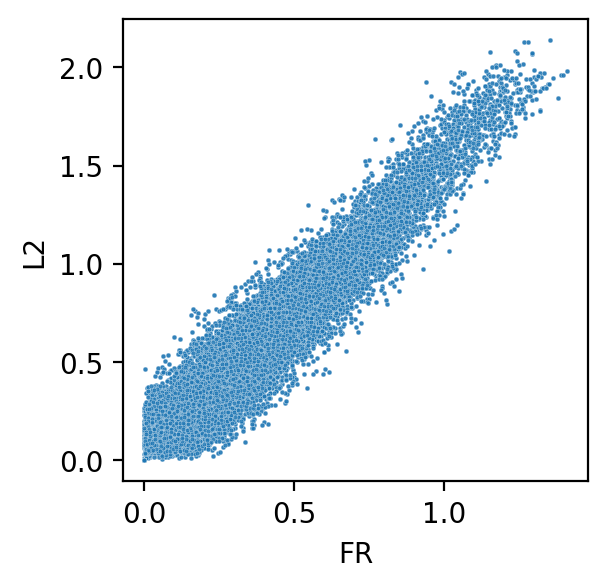

In [12]:
fig = plt.figure(figsize=(3,3), dpi=200)
sns.scatterplot(df, x='FR', y='L2', s=3, alpha=0.7)